In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget
import pickle
import os

from amftrack.util.sys import (

    update_plate_info,

    get_current_folders,
)

from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Experiment,
)

from amftrack.pipeline.functions.image_processing.experiment_class_surf import (
    Node,
)
from amftrack.pipeline.functions.post_processing.extract_study_zone import (
    load_study_zone,
)
from amftrack.pipeline.functions.post_processing.exp_plot import *
import pickle
import scipy.io as sio
import networkx as nx
import numpy as np
from sthype import SpatialGraph, HyperGraph
from sthype.graph_functions import spatial_temporal_graph_from_spatial_graphs

import matplotlib.pyplot as plt
import os
import pickle
from tqdm import tqdm
import pandas as pd
from amftrack.pipeline.functions.image_processing.experiment_util import (
    get_all_edges,
    get_all_nodes, get_timedelta_second,
)
from amftrack.pipeline.functions.transport_processing.high_mag_videos.temporal_graph_util import *
mpl.rcParams["figure.dpi"] = 100
import seaborn as sns
plt.style.use('presentation.mplstyle')
import logging

# Get the logger for 'fontTools'
font_tools_logger = logging.getLogger('fontTools')

# Set the logging level to WARNING, which ignores DEBUG and INFO messages
font_tools_logger.setLevel(logging.WARNING)

c:\users\coren\documents\phd\code\amftrack\amftrack\util\dbx.py:3: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [2]:
path_figure = r"C:\Users\coren\Documents\PhD\paper\transport\Fig1"

In [3]:
path_root = r"C:\Users\coren\AMOLF-SHIMIZU Dropbox\DATA\CocoTransport\graphs"
plates = [
    "441_20230807", "449_20230807", "310_20230830"
]
plate_id = plates[0]
path_tot = os.path.join(path_root,f"graph{plate_id}_video.pickle")
spatial_temporal_graph,folders = load(path_tot)

In [4]:
def merge_hyperedge(hyperdege0,hyperedge1,graph):
    edges = graph.get_hyperedge_edges(hyperedge1)
    edges_new = merge(edges, graph)
    for u,v in edges_new:
        graph[u][v]["hyperedge"] = hyperdege0
# #441
        
merge_hyperedge(3169,3728,spatial_temporal_graph)
merge_hyperedge(3169,3874,spatial_temporal_graph)
#310

# merge_hyperedge(335,443,spatial_temporal_graph)
# merge_hyperedge(31,133,spatial_temporal_graph)
# merge_hyperedge(242,171,spatial_temporal_graph)
# merge_hyperedge(1586,673,spatial_temporal_graph)
# merge_hyperedge(1586,780,spatial_temporal_graph)
# merge_hyperedge(167,1583,spatial_temporal_graph)
# merge_hyperedge(167,640,spatial_temporal_graph)

In [5]:
exp = make_exp(spatial_temporal_graph,folders)
weights = {(begin, end): LineString(data['pixel_list']).length * 1.725 for begin, end, data in
           spatial_temporal_graph.edges(data=True)}
nx.set_edge_attributes(spatial_temporal_graph, weights, "length")
weights = {(begin, end): data['pixel_list'][0][0] * 1.725 for begin, end, data in
           spatial_temporal_graph.edges(data=True)}
nx.set_edge_attributes(spatial_temporal_graph, weights, "x")
weights = {(begin, end): data['pixel_list'][0][1] * 1.725 for begin, end, data in
           spatial_temporal_graph.edges(data=True)}
nx.set_edge_attributes(spatial_temporal_graph, weights, "y")
# weights = {(begin, end): np.abs(data["42"]['speed_backflow2']) for begin, end, data in
#            spatial_temporal_graph.edges(data=True)}
# nx.set_edge_attributes(spatial_temporal_graph, weights, "abs_speed_backflow2_42")
# spatial_temporal_graph._hyperedges_initial_edges_gathered = True
# get_abcisse(spatial_temporal_graph)

In [6]:
refs = {
    "310_20230830": {
        "20230901_Plate310": "20230901_0719_Plate06",
        "20230902_Plate310": "20230902_1343_Plate07",
        "20230903_Plate310": "20230903_1143_Plate07",
        "20230904_Plate310": "20230904_0942_Plate07",
        "20230905_Plate310": "20230905_1345_Plate07",
        # "20230906_Plate310" : "20230906_1220_Plate07",
    },
    "441_20230807": {
        "20230810_Plate441": "20230810_1005_Plate14",
        "20230811_Plate441": "20230811_1605_Plate14",
        "20230812_Plate441": "20230812_1006_Plate14",
        "20230813_Plate441": "20230813_1618_Plate14",
    },
    "449_20230807": {
        "20230813_Plate449": "20230813_1606_Plate10",
        "20230814_Plate449": "20230814_1019_Plate10",
        "20230815_Plate449": "20230815_1021_Plate10",
        "20230816_Plate449": "20230816_1027_Plate10",
        # "20230818_Plate449": "20230818_1107_Plate10",
    },
}
indexes = refs[plate_id]

In [7]:
import matplotlib.patches as patches
def show_region(region,ax,downsizing = 5):
    adjusted_region = [[coord / downsizing for coord in point] for point in region]

    # Display the image (assuming 'image' is your loaded image)
    # ax.imshow(image)

    # Calculate rectangle parameters
    x0, y0 = adjusted_region[0]  # Lower-left corner
    x1, y1 = adjusted_region[1]  # Upper-right corner
    print(x0,y0,x1,y1)
    # Create a rectangle patch
    rect = patches.Rectangle((y0, x0), y1 - y0, x1 - x0, linewidth=2, edgecolor='g', facecolor='none',alpha = 0.8)
    ax.add_patch(rect)

In [8]:
def check_has_video(edge,graph):
    for i in range(graph.max_age+1):
        if 'video_edge' in graph[edge[0]][edge[1]][str(i)]:
            return(True)
    return(False)

In [9]:
edges_info = [edge for edge in spatial_temporal_graph.edges() if check_has_video(edge,spatial_temporal_graph)]

In [10]:
all_infos = pd.DataFrame()
attribute_list = ["QBC_tot","QBC_net","water_flux","speed_backflow","speed_heaton","water_flux_heaton","speed_backflow2"]
static_atrribute = ["hyperedge",
                    "abcisse",
                    "x",
                    "y",
                   ]
edge_specific_attribute = ["ordered_mapping","R","mapping"]
iss = []
for edge in edges_info:
    for i in range(spatial_temporal_graph.max_age+1):
         if 'video_edge' in spatial_temporal_graph[edge[0]][edge[1]][str(i)]:
            if i not in iss:
                iss.append(i)
                # print(i,spatial_temporal_graph[edge[0]][edge[1]][str(i)]['video_edge'])
            network_edge_infos = spatial_temporal_graph[edge[0]][edge[1]]
            for j in range(len(network_edge_infos[str(i)]['video_edge'])):
                edge_obj = spatial_temporal_graph[edge[0]][edge[1]][str(i)]['video_edge'][j]
                x1 = spatial_temporal_graph.nodes[edge[0]]['position'].x
                x2 = spatial_temporal_graph.nodes[edge[1]]['position'].x
                for attribute in attribute_list:
                    if attribute in network_edge_infos[str(i)]:
                        edge_obj.mean_data[attribute]=network_edge_infos[str(i)][attribute]
                for attribute in edge_specific_attribute:
                    edge_obj.mean_data[attribute]=network_edge_infos[str(i)][attribute][j]
                for attribute in static_atrribute:
                    if attribute in network_edge_infos:
                        edge_obj.mean_data[attribute]=network_edge_infos[attribute]
                edge_data_csv = edge_obj.mean_data
                edge_data_csv['folder'] = folders["folder"].iloc[i]
                edge_data_csv['edge_network'] = edge

                if "water_flux" in edge_data_csv.keys():
                    edge_data_csv['ordered_final'] = -edge_data_csv['ordered_mapping']

                    edge_data_csv['ordered_final'] *= (1-2*(edge[0]>edge[1]))
                    edge_data_csv['ordered_final'] *= (1-2*(x1>x2))
                    # edge_data_csv['ordered_final'] *= (1-2*(edge_data_csv['water_flux']>0))

                edge_data_csv = pd.DataFrame(edge_data_csv).transpose()
                all_infos = pd.concat([all_infos,edge_data_csv])
    # break

In [11]:
# region = [[3000*5,5000*5],[5250*5,7500*5]]
minx = 0*5
maxx = 25000
miny = 6000*5

maxy = 44000
list_video = [114,88,70]
window_sizex = 3000*1.725/25
window_sizey = 4096*1.725/25
regions = []
select = all_infos[all_infos['folder']=='20230812_1006_Plate14']
select = select[select["video_int"].isin(list_video)]
for video_int in list_video:
    select_video = select[select["video_int"]==video_int].iloc[0]
    x,y = select_video["x"]/1.725,select_video["y"]/1.725
    beginx = x-window_sizex-minx
    endx = x+window_sizex-minx
    beginy = y-window_sizey-miny
    endy = y+window_sizey-miny
    regions.append([[beginx,beginy],[endx,endy]])


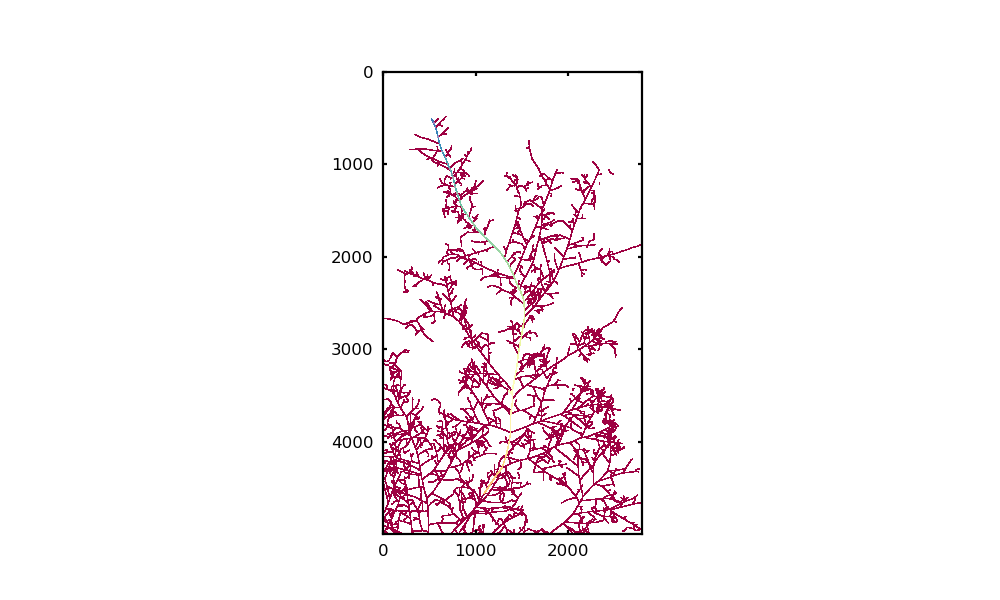

3941.9057022072498 1310.198145495556 4024.70570220725 1423.2477454955574
3308.8473550362714 1260.9423937791173 3391.6473550362716 1373.9919937791187
2462.889662367945 1467.5371231777258 2545.689662367945 1580.5867231777272


In [12]:
def color_edge(edge):
    if (edge.get_attribute("hyperedge",t) ==3169):
        return(30000-(edge.get_attribute("x",t)))
    else:
        return(-30000)
exp = make_exp(spatial_temporal_graph,folders)
from amftrack.pipeline.functions.image_processing.experiment_util import (
    plot_edge_color_value,
)
from matplotlib import cm

vmax = 30000
vmin = -30000
t=0


region = [[minx,miny],[maxx,maxy]]
# region = [[0*5,6000*5],[25000,44000]]

fig, ax,f = plot_edge_color_value_3(
    exp,
    t,
    # lambda edge : edge.get_attribute("abcisse",t) ==3169,
    lambda edge : color_edge(edge),
    
    cmap=cm.get_cmap("Spectral", 100),
    v_min=vmin,
    v_max=vmax,
    plot_cmap=True,
    show_background=False,
    dilation=15,
    figsize=(5, 3),
    alpha = 1,
    region = region
)

for region in regions:
    show_region(region,ax)
plt.xticks([])  # Removes 
plt.yticks([])  # Removes x-ticks and x-tick labelsx-ticks and x-tick labels
plt.savefig(
    os.path.join(path_figure, f"profile_hypha.pdf"),
    transparent=True,
    bbox_inches="tight",
)

In [13]:
# all_infos['abcisse'] = all_infos['abcisse'].astype(float)
all_infos['negx'] = 40000-all_infos['x']
all_infos['relative_flux'] = (all_infos["flux_left"]+all_infos['flux_right'])/(all_infos["flux_left"]-all_infos['flux_right'])*2

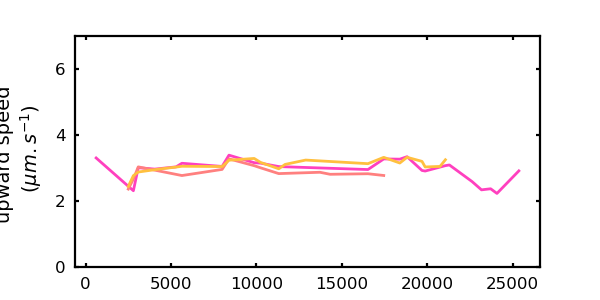

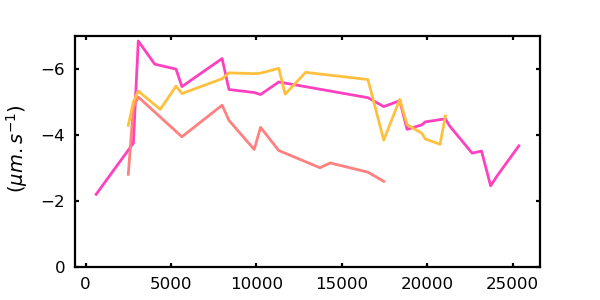

In [14]:

plt.close("all")
all_infos["ordered_heaton"] = all_infos['ordered_final']*(1-2*(all_infos['speed_heaton']>0))
all_infos["ordered_backflow"] = all_infos['ordered_final']*(1-2*(all_infos['speed_backflow2']>0))
all_infos["abs_speed_backflow2"] = -np.abs(all_infos['speed_backflow2'])
all_infos["abs_speed_heaton"] = np.abs(all_infos['speed_heaton'])*10


select = all_infos[all_infos['mapping']<10]
select = select[select['coverage_tot']>=0.1]
select = select[select['mode']=="BF"]
select = select[select['hyperedge']==3169]
fig,ax = plt.subplots(figsize = (3,1.5))

sns.lineplot(select,x="negx",y="speed_right",hue = 'folder',palette="spring",errorbar= None)
# sns.lineplot(select,x="negx",y="speed_left",hue = 'folder',palette="spring")
ax.set_ylim(0,7)
plt.gca().get_legend().remove()  # This removes the legend
ax.set_xlabel("curvilinear coordinate ($\mu m$)")
ax.set_ylabel("upward speed \n ($\mu m.s^{-1}$)")
plt.savefig(
    os.path.join(path_figure, f"upward_speed.pdf"),
    transparent=True,
    bbox_inches="tight",
)
fig,ax = plt.subplots(figsize = (3,1.5))

sns.lineplot(select,x="negx",y="speed_left",hue = 'folder',palette="spring",errorbar= None)
# sns.lineplot(select,x="negx",y="speed_left",hue = 'folder',palette="spring")
ax.set_ylim(0,-7)
plt.gca().get_legend().remove()  # This removes the legend
ax.set_xlabel("curvilinear coordinate ($\mu m$)")
ax.set_ylabel("downward speed \n ($\mu m.s^{-1}$)")
plt.savefig(
    os.path.join(path_figure, f"downward_speed.pdf"),
    transparent=True,
    bbox_inches="tight",
)
# selectm = select[select['ordered_backflow']==-1]
# sns.lineplot(selectm,x = "negx",y= "abs_speed_heaton",hue = "folder",ax = ax2)
# ax2 = ax.twinx()
# ax2.set_ylim(-7,7)

# sns.lineplot(selectm,x = "negx",y= "abs_speed_backflow2",hue = "folder",ax = ax2)

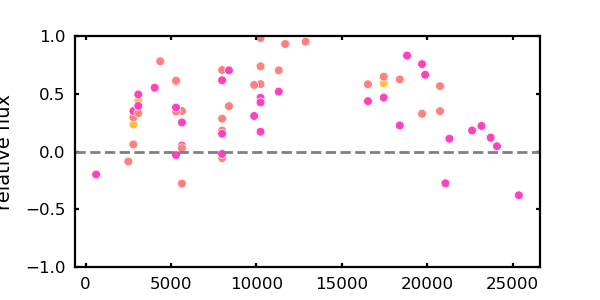

In [15]:
fig,ax = plt.subplots(figsize = (3,1.5))
select = all_infos[all_infos['mapping']<10]
select = select[select['coverage_tot']>=0.1]
select = select[select['mode']=="F"]
select = select[select['hyperedge']==3169]
# select = select[select['folder']=='20230812_1006_Plate14']

sns.scatterplot(select,x = "negx",y= "relative_flux",hue = "folder",s = 10,palette="spring")

ax.set_ylim(-1,1)
ax.axhline(y=0, color='gray', linestyle='--')
plt.gca().get_legend().remove()  # This removes the legend
ax.set_xlabel("curvilinear coordinate ($\mu m$)")
ax.set_ylabel("relative flux")
plt.savefig(
    os.path.join(path_figure, f"flux.pdf"),
    transparent=True,
    bbox_inches="tight",
)

In [16]:
all_infos

,Unnamed: 0,edge_name,edge_length,straight_length,speed_max,speed_min,speed_mean,flux_avg,flux_min,flux_max,...,speed_heaton,water_flux_heaton,speed_backflow2,ordered_final,negx,relative_flux,ordered_heaton,ordered_backflow,abs_speed_backflow2,abs_speed_heaton
0,0,"(15, 3)",52.302,53.332492,8.454665,-7.525011,0.114735,0.266927,-13.58674,16.656793,...,NaN,NaN,NaN,NaN,9999.739221,0.186719,NaN,NaN,NaN,NaN
0,0,"(14, 2)",48.024,49.990488,8.757517,-9.91487,-0.007594,-0.003475,-24.244552,22.105572,...,NaN,NaN,NaN,NaN,9999.739221,-0.052831,NaN,NaN,NaN,NaN
0,0,"(19, 14)",26.358,31.159899,5.242049,-5.108158,-0.372546,-7.596473,-81.486954,50.383391,...,NaN,NaN,NaN,NaN,9999.739221,-0.371279,NaN,NaN,NaN,NaN
0,0,"(14, 7)",78.384,66.71697,5.947819,-5.746166,0.118272,0.252689,-8.513227,9.830735,...,NaN,NaN,NaN,NaN,9999.739221,0.212459,NaN,NaN,NaN,NaN
0,0,"(19, 6)",46.506,55.11662,7.499204,-7.365325,0.058497,0.149636,-13.056027,15.09174,...,NaN,NaN,NaN,NaN,9999.739221,0.03481,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0,"(98, 61)",39.468,46.137839,4.920211,-3.798782,0.341126,7.167012,-42.173011,75.366255,...,0.046085,1.473752,-0.46085,-1,24658.824841,0.147749,1,-1,-0.46085,0.46085
0,0,"(4, 1)",70.794,70.916426,5.621613,-11.25531,1.279334,29.975503,-62.886773,117.595738,...,-0.01981,-0.658847,0.197931,1,16082.457616,0.34091,1,-1,-0.197931,0.198101
0,0,"(4, 1)",70.794,70.916426,4.087508,-7.4632,1.571259,31.1009,-18.049411,89.250022,...,-0.01981,-0.658847,0.197931,1,16082.457616,0.928585,1,-1,-0.197931,0.198101
0,0,"(40, 3)",71.898,72.204997,8.009183,-10.722351,-0.508657,-4.217665,-66.822734,48.429865,...,0.00293,0.101475,-0.029552,1,16082.457616,-0.296482,-1,1,-0.029552,0.029301


In [17]:
all_infos = pd.DataFrame()
for plate_id in plates:
    path_tot = os.path.join(path_root,f"graph{plate_id}_video.pickle")
    spatial_temporal_graph,folders = load(path_tot)
    edges_info = [edge for edge in spatial_temporal_graph.edges() if check_has_video(edge,spatial_temporal_graph)]
    attribute_list = ["QBC_tot","QBC_net","water_flux","speed_backflow","speed_heaton","water_flux_heaton","speed_backflow2"]
    static_atrribute = ["hyperedge",
                        # "abcisse",
                        # "x",
                        # "y",
                       ]
    edge_specific_attribute = ["ordered_mapping","R","mapping"]
    iss = []
    for edge in edges_info:
        for i in range(spatial_temporal_graph.max_age+1):
             if 'video_edge' in spatial_temporal_graph[edge[0]][edge[1]][str(i)]:
                if i not in iss:
                    iss.append(i)
                    # print(i,spatial_temporal_graph[edge[0]][edge[1]][str(i)]['video_edge'])
                network_edge_infos = spatial_temporal_graph[edge[0]][edge[1]]
                for j in range(len(network_edge_infos[str(i)]['video_edge'])):
                    edge_obj = spatial_temporal_graph[edge[0]][edge[1]][str(i)]['video_edge'][j]
                    x1 = spatial_temporal_graph.nodes[edge[0]]['position'].x
                    x2 = spatial_temporal_graph.nodes[edge[1]]['position'].x
                    for attribute in attribute_list:
                        if attribute in network_edge_infos[str(i)]:
                            edge_obj.mean_data[attribute]=network_edge_infos[str(i)][attribute]
                    for attribute in edge_specific_attribute:
                        edge_obj.mean_data[attribute]=network_edge_infos[str(i)][attribute][j]
                    for attribute in static_atrribute:
                        if attribute in network_edge_infos:
                            edge_obj.mean_data[attribute]=network_edge_infos[attribute]
                    edge_data_csv = edge_obj.mean_data
                    edge_data_csv['folder'] = folders["folder"].iloc[i]
                    edge_data_csv['edge_network'] = edge
                    edge_data_csv['plate_id'] = plate_id

                    if "water_flux" in edge_data_csv.keys():
                        edge_data_csv['ordered_final'] = -edge_data_csv['ordered_mapping']

                        edge_data_csv['ordered_final'] *= (1-2*(edge[0]>edge[1]))
                        edge_data_csv['ordered_final'] *= (1-2*(x1>x2))
                        # edge_data_csv['ordered_final'] *= (1-2*(edge_data_csv['water_flux']>0))

                    edge_data_csv = pd.DataFrame(edge_data_csv).transpose()
                    all_infos = pd.concat([all_infos,edge_data_csv])
    # break

In [35]:
all_infos['relative_flux'] = (all_infos["flux_left"]+all_infos['flux_right'])/(all_infos["flux_left"]-all_infos['flux_right'])*2
all_infos["ordered_heaton"] = all_infos['ordered_final']*(1-2*(all_infos['speed_heaton']>0))


In [36]:
infos_F = all_infos.loc[all_infos['mode']=='F']
infos_F.drop(['edge_length','straight_length',"mode"],axis = 1)
infos_BF = all_infos.loc[all_infos['mode']=='BF']
infos_BF = infos_BF.drop(['mode'], axis=1)
merged_df = infos_F.merge(infos_BF,on = ["xpos","ypos","plate_id","edge_network"],suffixes=("F","BF"))

In [37]:
merged_df['speed_lipid'] = np.abs(np.where(merged_df['relative_fluxF'] > 0, merged_df['speed_rightBF'], merged_df['speed_leftBF']))
merged_df['speed_other'] = np.abs(np.where(merged_df['relative_fluxF'] <= 0, merged_df['speed_rightBF'], merged_df['speed_leftBF']))
merged_df['speed_real'] = np.abs(np.where(merged_df['ordered_heatonBF'] > 0, merged_df['speed_rightBF'], merged_df['speed_leftBF']))
merged_df['speed_other2'] = np.abs(np.where(merged_df['ordered_heatonBF'] <= 0, merged_df['speed_rightBF'], merged_df['speed_leftBF']))

In [21]:
len(all_infos)

4804

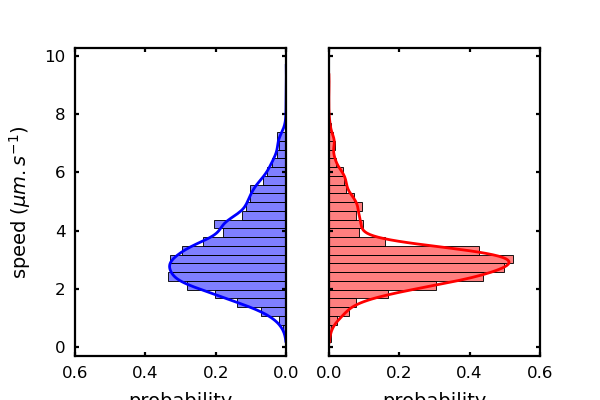

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

fig, (ax2, ax1) = plt.subplots(1, 2, figsize=(3, 2), sharey=True)  # Create two subplots sharing the y-axis

# Filter data
select = merged_df[merged_df['coverage_totBF'] >= 0.1]
select = select[np.abs(select['relative_fluxF']) >= 0.1]
bin_width = 0.3  # Set bin width
bins = np.arange(select[['speed_lipid', 'speed_other']].min().min(),
                 select[['speed_lipid', 'speed_other']].max().max() + bin_width,
                 bin_width)

# Plot the first histogram for 'speed_lipid' horizontally
sns.histplot(select, y='speed_lipid', stat="density", kde=True, ax=ax1, color="red", bins=bins, orientation='horizontal')

# Plot the second histogram for 'speed_other' horizontally and invert x-axis
sns.histplot(select, y='speed_other', stat="density", kde=True, ax=ax2, color="blue", bins=bins, orientation='horizontal')
ax2.invert_xaxis()  # Invert the x-axis for the second histogram

# Set x-axis limits for both subplots for consistency
ax1.set_xlim(0, 0.6)
ax2.set_xlim(0.6, 0)  # Inverted limits
ax2.set_ylabel("speed ($\mu m.s^{-1}$)")
ax1.set_xlabel("probability")
ax2.set_xlabel("probability")
plt.savefig(
    os.path.join(path_figure, f"speed_distrib.pdf"),
    transparent=True,
    bbox_inches="tight",
)


C:\Users\coren\AppData\Local\Temp\ipykernel_16648\3885155987.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,ax = plt.subplots(figsize=(3, 2))


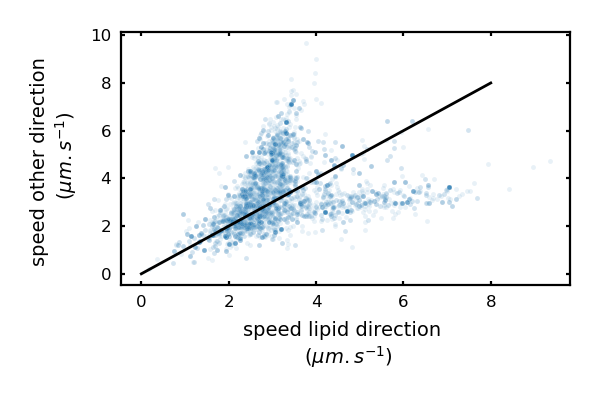

In [44]:
fig,ax = plt.subplots(figsize=(3, 2))
sns.scatterplot(select,x='speed_real', y='speed_other2',alpha = 0.1,s=3)
ax.set_ylabel("speed other direction \n ($\mu m.s^{-1}$)")
ax.set_xlabel("speed lipid direction \n ($\mu m.s^{-1}$)")
ax.plot([0,8],[0,8],color = "black")
plt.tight_layout()

In [23]:
hzrhz

NameError: name 'hzrhz' is not defined

In [ ]:
fig,ax = plt.subplots()
all_infos["ordered_heaton"] = all_infos['ordered_final']*(1-2*(all_infos['speed_heaton']>0))
select = all_infos[all_infos['mapping']<10]
select = select[select['coverage_tot']>=0.1]
select = select[select['mode']=="BF"]

selectm = select[select['ordered_heaton']==1]
ax.scatter(np.abs(selectm["speed_heaton"]),selectm["speed_right"])
selectp = select[select['ordered_heaton']==-1]

ax.scatter(np.abs(selectp["speed_heaton"]),-selectp["speed_left"])

In [ ]:
fig,ax = plt.subplots()
all_infos["ordered_backflow"] = all_infos['ordered_final']*(1-2*(all_infos['speed_backflow2']>0))
select = all_infos[all_infos['mapping']<10]
select = select[select['coverage_tot']>=0.1]
select = select[select['mode']=="BF"]

selectm = select[select['ordered_backflow']==1]
ax.scatter(np.abs(selectm["speed_backflow2"]),selectm["speed_right"])
selectp = select[select['ordered_backflow']==-1]

ax.scatter(np.abs(selectp["speed_backflow2"]),-selectp["speed_left"])

In [ ]:
fig,ax = plt.subplots()
all_infos["ordered_Cflux"] = all_infos['ordered_final']*(1-2*(all_infos['QBC_net']>0))
select = all_infos[all_infos['mapping']<10]
select = select[select['coverage_tot']>=0.1]
select = select[select['mode']=="BF"]
select = select[np.abs(select['QBC_net'])>0]

selectm = select[select['ordered_Cflux']==-1]
ax.scatter(np.abs(selectm["QBC_net"]),selectm["speed_right"])
selectp = select[select['ordered_Cflux']==1]

ax.scatter(np.abs(selectp["QBC_net"]),-selectp["speed_left"])

In [ ]:
fig,ax = plt.subplots()
all_infos["ordered_Cflux"] = all_infos['ordered_final']*(1-2*(edge_data_csv['QBC_net']>0))
select = all_infos[all_infos['mapping']<10]
select = select[select['coverage_tot']>=0.1]
select = select[select['mode']=="BF"]
select = select[np.abs(select['QBC_net'])>0]

selectm = select[select['ordered_Cflux']==-1]
ax.scatter(np.abs(selectm["QBC_net"]),selectm["speed_right"])
selectp = select[select['ordered_Cflux']==1]

ax.scatter(np.abs(selectp["QBC_net"]),-selectp["speed_left"])

In [ ]:
len(select["ordered_heaton"])

In [ ]:
select = select[np.abs(select['ordered_final'])>0]
len(selectm)+len(selectp)

In [ ]:
fig,ax = plt.subplots()
all_infos['speed_left_abs'] = np.abs(all_infos['speed_left'])
all_infos['max_speed'] = all_infos[['speed_right', 'speed_left_abs']].max(axis=1)
all_infos['min_speed'] = all_infos[['speed_right', 'speed_left_abs']].min(axis=1)
select = all_infos[all_infos['mapping']<100]
select = select[select['coverage_tot']>=0.1]
select = select[select['mode']=="BF"]
# selectm = select[select['ordered_final']==-1]

ax.scatter(abs(select["speed_right"]),abs(select["speed_left_abs"]))

In [ ]:
fig,ax = plt.subplots()
all_infos['speed_left_abs'] = np.abs(all_infos['speed_left'])
all_infos['max_speed'] = all_infos[['speed_right', 'speed_left_abs']].max(axis=1)
all_infos['min_speed'] = all_infos[['speed_right', 'speed_left_abs']].min(axis=1)
select = all_infos[all_infos['mapping']<100]
select = select[select['coverage_tot']>=0.1]
select = select[select['mode']=="BF"]
# selectm = select[select['ordered_final']==-1]

ax.scatter(abs(select["min_speed"]),abs(select["max_speed"]))

In [ ]:
fig,ax = plt.subplots()
select = all_infos[all_infos['mapping']<10]
select = select[select['coverage_tot']>=0.1]
select = select[select['mode']=="BF"]
selectm = select[select['ordered_final']==1]

ax.scatter(np.abs(selectm["water_flux"]),selectm["speed_right"])
selectp = select[select['ordered_final']==-1]
selectp = select[select['speed_left']<0]

ax.scatter(np.abs(selectp["water_flux"]),np.abs(selectp["speed_left"]))
sns.regplot(x = np.abs(selectp["water_flux"]).astype("float"),y=np.abs(selectp["speed_left"]).astype("float"))

In [ ]:
fig,ax = plt.subplots()
select = all_infos[all_infos['mapping']<10]
select = select[select['coverage_tot']>=0.1]
select = select[select['QBC_tot']>0]

select = select[select['mode']=="F"]
selectm = select[select['ordered_final']==1]

ax.scatter(selectm["QBC_net"],selectm["flux_avg"])
selectp = select[select['ordered_final']==-1]
# selectp = select[select['speed_left']<0]

ax.scatter(selectp["QBC_net"],-selectp["flux_avg"])


In [ ]:
np.sign((all_infos['flux_avg']*all_infos["QBC_net"]*all_infos["ordered_final"]).astype(float))

In [ ]:
all_infos['aligned'] = np.sign((all_infos['flux_avg']*all_infos["QBC_net"]*all_infos["ordered_final"]).astype(float))

In [ ]:
# Assuming 'select' is your DataFrame filtered based on previous conditions.
plate_ids = all_infos['plate_id'].unique()
plate_ids_names = [plate_id.split("_")[0] for plate_id in plate_ids]
num_plate_ids = len(plate_ids)

# Prepare figure
fig, ax = plt.subplots(figsize=(10/2 + num_plate_ids/2, 3))  # Adjust figure size based on the number of plate_ids

# Bar plot settings
bar_width = 0.2
index = np.arange(num_plate_ids)
color_1 = 'orange'
color_2 = 'green'

# Initialize containers for bar positions and heights
positions_1 = []
positions_2 = []
heights_1 = []
heights_2 = []

# Loop through each plate_id to get proportions
for i, plate_id in enumerate(plate_ids):
    subset = all_infos[all_infos['plate_id'] == plate_id]
    subset = subset[(subset['coverage_tot'] > 0.05) & 
               (subset['speed_right'] <= 15) & 
               (subset['mode'] <= "F") & 
               (subset['mapping'] <= 10) &
               (subset['QBC_tot'] > 0) 
                    
                   ]
    aligned_counts = subset['aligned'].value_counts(normalize=True).reindex([-1, 1], fill_value=0) * 100
    # aligned2_counts = subset['aligned2'].value_counts(normalize=True).reindex([-1, 1], fill_value=0) * 100
    
    # Plot bars for this plate_id
    pos_1 = index[i] - bar_width/1.5
    pos_2 = index[i] + bar_width/1.5
    
    positions_1.append(pos_1)
    positions_2.append(pos_2)
    heights_1.extend([aligned_counts[-1], aligned_counts[1]])
    # heights_2.extend([aligned2_counts[-1], aligned2_counts[1]])
    
    ax.bar(pos_1, aligned_counts[-1], bar_width, label='-1 in Aligned' if i == 0 else "", color=color_1)
    ax.bar(pos_1, aligned_counts[1], bar_width, bottom=aligned_counts[-1], label='1 in Aligned' if i == 0 else "", color=color_2)
    
#     ax.bar(pos_2, aligned2_counts[-1], bar_width, label='-1 in Aligned2' if i == 0 else "", color=color_1,hatch = "/")
#     ax.bar(pos_2, aligned2_counts[1], bar_width, bottom=aligned2_counts[-1], label='1 in Aligned2' if i == 0 else "", color=color_2,hatch = "/")

# Add labels, title, and custom x-axis tick labels
ax.set_xlabel('date')
ax.set_ylabel('Percentage')
# ax.set_title('Proportion of -1 and 1 in Aligned and Aligned2 by Plate ID')
ax.set_xticks(index)
ax.set_xticklabels(plate_ids_names, rotation=45)
ax.set_ylim(0, 100)
ax.hlines(50,-bar_width*1.5,len(index)-1+bar_width*1.5,color="black",linestyle="dashed")
# ax.legend()

plt.tight_layout()
plt.show()

In [ ]:
selectm.iloc[0]['folder']

In [ ]:
selectm.iloc[0]['video_int']

In [ ]:
selectm.iloc[0]['speed_right']

In [ ]:
selectm.iloc[0]['edge_name']

In [ ]:
len(selectm)+len(selectp)

In [ ]:
selectm['folder'].unique()

In [ ]:
select = all_infos.loc[all_infos['video_int']==52]
select = select.loc[select['edge_name']=="(33, 9)"]
select['water_flux'],select['speed_left'],select['speed_right'],select["ordered_final"]

In [ ]:
select['ordered_mapping'],select['edge_network']

In [ ]:
edge = select['edge_network'].iloc[0]
edge

In [ ]:
x1 = spatial_temporal_graph.nodes[edge[0]]['position'].x
x2 = spatial_temporal_graph.nodes[edge[1]]['position'].x
x1,x2

In [ ]:
nodes = [Node(label,exp) for label in select['edge_network'].iloc[0]]
nodes

In [ ]:
from amftrack.pipeline.functions.transport_processing.high_mag_videos.plotting import *
from matplotlib import cm
downsizing = 5
t=0

fig, ax,f = plot_edge_color_value_3(
    exp,
    t,
    lambda edge : 2,
    cmap=cm.get_cmap("viridis", 100),
    plot_cmap=True,
    show_background=False,
    dilation=10,
    figsize=(12, 9),
    alpha = 1,
    v_min = 0,
    v_max = 0.2,
    region = region,
    nodes = nodes

)

In [ ]:
all_infos['ordered']

In [ ]:
G = exp1.nx_graph[0]
speeds = [abs(G[u][v]['speed']) for u, v in G.edges()]
fluxes = [G[u][v]['QBC_net'] for u, v in G.edges()]
fig,ax = plt.subplots()
ax.hist(speeds,30)
# ax.hist(fluxes2,30,alpha = 0.5)
ax.set_yscale("log")

In [ ]:
from amftrack.pipeline.functions.transport_processing.high_mag_videos.plotting import *
from matplotlib import cm
downsizing = 5
t=0
region = [[0*5,0*5],[26000,52000]]

fig, ax,f = plot_edge_color_value_3(
    exp1,
    t,
    lambda edge : abs(edge.get_attribute("speed",t)),
    cmap=cm.get_cmap("viridis", 100),
    plot_cmap=True,
    show_background=False,
    dilation=10,
    figsize=(5, 3),
    alpha = 1,
    v_min = 0,
    v_max = 0.2,
    region = region
    # nodes = non_zero

)

In [ ]:
region = [[3750*5,4500*5],[5250*5,8000*5]]

plot_region(exp1,region,"water_flux",0.3)